In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import pyntcloud

from pathlib import Path
from matplotlib import image as mpimg
from src.geometry.point_transformation import cull_coordinates_ids
from src.geometry.point_transformation_pt import *

In [2]:
south_building_model = torch.load("../results/south-building/ckpts/ckpt_6999_rank0.pt", map_location="cpu", weights_only=True)
f"There is {len(south_building_model['splats']['means'])} splats"

'There is 530060 splats'

In [3]:
recon_path = Path("../data/south-building/0")
images_folder = Path("../data/south-building/images")

In [4]:
device=torch.device("cpu")

In [7]:
pcd = pyntcloud.PyntCloud.from_file("../data/south-building/sparse.ply")

In [9]:
pcd.points

,x,y,z,red,green,blue
0,-0.291721,-0.584570,-0.378086,188,162,149
1,1.368953,-0.165136,1.435727,58,54,44
2,0.569459,-1.404836,-0.067789,187,189,186
3,1.057811,-1.299900,-0.013460,127,124,119
4,-2.348771,-0.452898,1.599209,194,165,146
...,...,...,...,...,...,...
57708,-1.399897,-0.477998,-0.395609,137,113,110
57709,-2.827137,-0.199658,-0.673929,11,18,12
57710,-2.781327,0.078456,1.374065,148,123,115
57711,-1.406662,-0.756747,1.985507,91,87,81


In [15]:
reconstruction = pycolmap.Reconstruction(recon_path)
# pcd = o3d.io.read_point_cloud("../data/south-building/sparse.ply")
recon_points = torch.tensor(pcd.points[['x', 'y', 'z']].values, device=device)
recon_colors = torch.tensor(pcd.points[['red', 'green', 'blue']].values / 255.0, device=device)

img_id = 50
img = reconstruction.images[img_id]
cam_id = 1
image = mpimg.imread(images_folder / f'{img.name}')

extrinsic_matrix = get_extrinsic_params(img.cam_from_world, device=device)
f, cx, cy = reconstruction.cameras[cam_id].params
f_pt = torch.scalar_tensor(f, device=device, dtype=torch.float32)
width, height = reconstruction.cameras[cam_id].width, reconstruction.cameras[cam_id].height
znear, zfar = 1, 5
intrinsic_matrix = get_intrinsic_opengl_params(f, f, height, width, zfar=zfar, znear=znear, device=device)
W = torch.tensor(extrinsic_matrix[:3, :3].T, device=device, dtype=torch.float32) # viewing transformation

image_pt = torch.tensor(image / 255.0, device=device)

C:\Users\julia\AppData\Local\Temp\ipykernel_21440\129522122.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W = torch.tensor(extrinsic_matrix[:3, :3].T, device=device, dtype=torch.float32) # viewing transformation


In [16]:
homogeneous_points = convert_to_homogenous(recon_points)
camera_coordinates = homogeneous_points @ extrinsic_matrix.T
clip_coordinates = camera_coordinates @ intrinsic_matrix.T
point_ids = cull_coordinates_ids(clip_coordinates, camera_coordinates, zfar=zfar, znear=znear)
ndc_coordinates = to_ndc_coordinates(clip_coordinates[point_ids])
screen_coordinates = to_screen_coordinates(ndc_coordinates, width, height, zfar, znear)
c = recon_colors[point_ids]

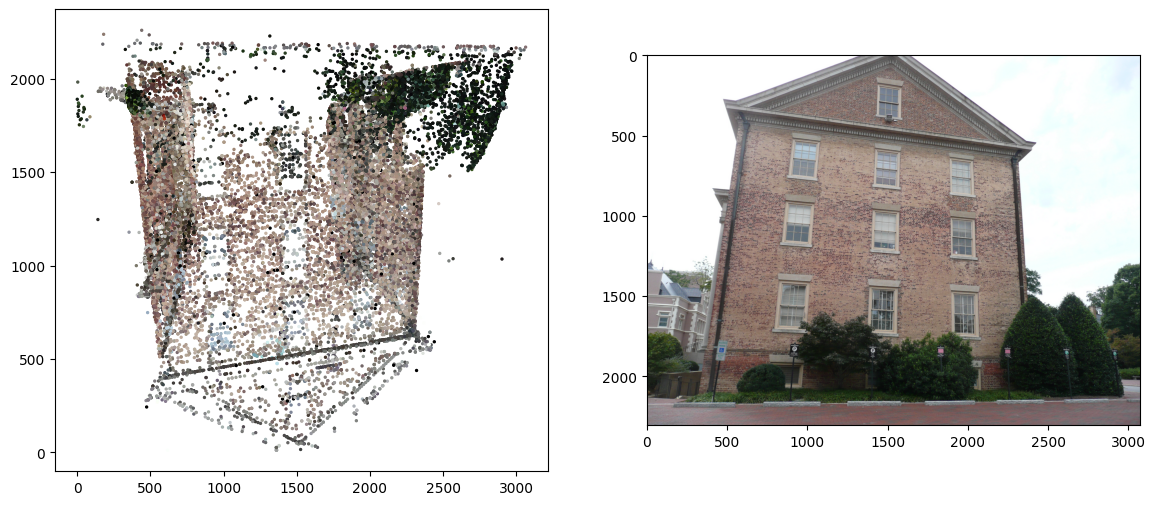

In [17]:
screen_coordinates_np = screen_coordinates.clone().detach().to('cpu')
image = mpimg.imread(images_folder / f'{img.name}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(screen_coordinates_np[:, 0], screen_coordinates_np[:, 1], s=2, c=c.clone().detach().to('cpu'))
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()

In [18]:
points = torch.tensor(south_building_model['splats']['means'], device=device)

homogeneous_points_g = convert_to_homogenous(points)
camera_coordinates_g = homogeneous_points_g @ extrinsic_matrix.T
clip_coordinates_g = camera_coordinates_g @ intrinsic_matrix.T
point_ids_g = cull_coordinates_ids(clip_coordinates_g, camera_coordinates_g, zfar=zfar, znear=znear)
ndc_coordinates_g = to_ndc_coordinates(clip_coordinates_g[point_ids_g])
screen_coordinates_g = to_screen_coordinates(ndc_coordinates_g, width, height, zfar, znear)

C:\Users\julia\AppData\Local\Temp\ipykernel_21440\246360248.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points = torch.tensor(south_building_model['splats']['means'], device=device)


In [19]:
torch.sum(point_ids_g)

tensor(254800)

In [20]:
point_ids_g

tensor([ True, False,  True,  ..., False, False, False])

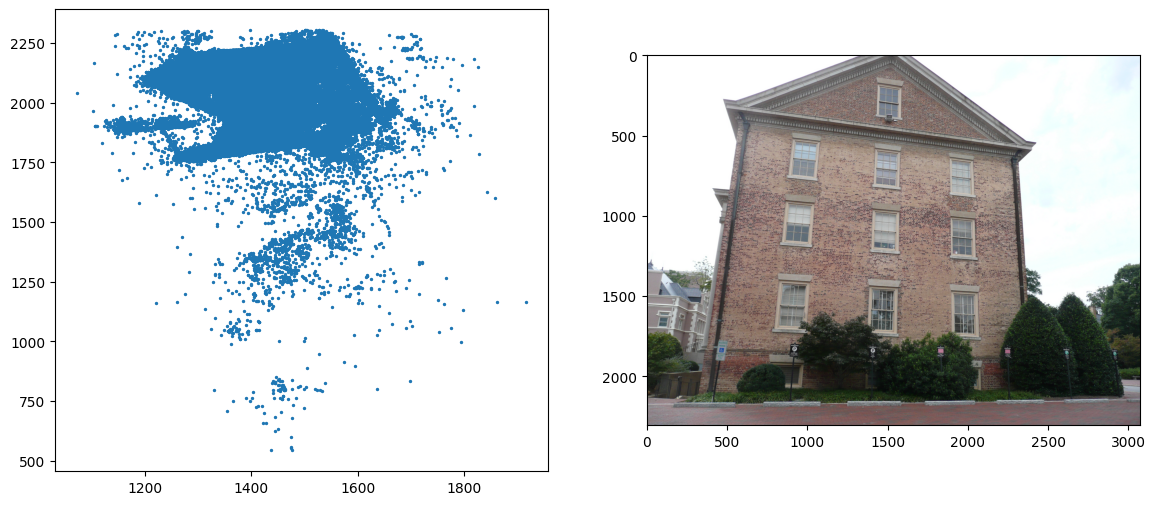

In [21]:
screen_coordinates_np = screen_coordinates_g.clone().detach().to('cpu')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(screen_coordinates_np[:, 0], screen_coordinates_np[:, 1], s=2)
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()

(array([6.30000e+01, 1.70000e+01, 7.25000e+02, 1.40200e+03, 4.27900e+03,
        1.23758e+05, 2.37468e+05, 2.84309e+05, 1.12018e+05, 3.61000e+02]),
 array([-2.36553955, -2.0357976 , -1.7060554 , -1.37631345, -1.04657137,
        -0.7168293 , -0.38708735, -0.05734515,  0.2723968 ,  0.60213876,
         0.93188089]),
 <BarContainer object of 10 artists>)

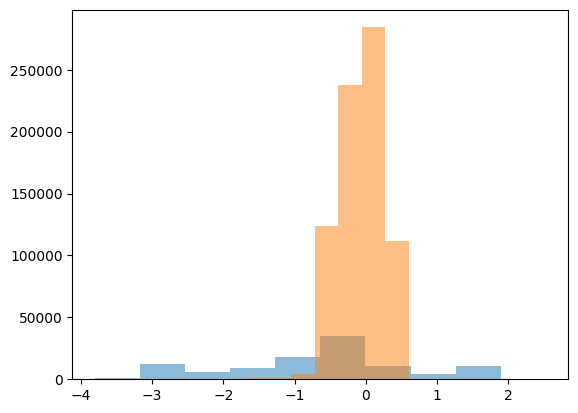

In [22]:
plt.hist(recon_points[point_ids].flatten(), alpha=0.5)
plt.hist(points[point_ids_g].flatten(), alpha=0.5)

In [25]:
south_building_model['splats']['sh0']

tensor([[[ 1.6426,  1.6522,  1.6482]],

        [[ 0.2084, -0.0294, -0.1009]],

        [[-0.0896, -0.4920, -0.5634]],

        ...,

        [[ 0.9499,  0.9503,  0.8705]],

        [[ 0.4267,  0.2004,  0.3533]],

        [[ 1.9492,  1.9513,  2.1186]]])

Help on class PyntCloud in module pyntcloud.core_class:

class PyntCloud(builtins.object)
 |  PyntCloud(points, mesh=None, structures=None, **kwargs)
 |  
 |  A Pythonic Point Cloud.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, points, mesh=None, structures=None, **kwargs)
 |      Create PyntCloud.
 |      
 |      Parameters
 |      ----------
 |      points: pd.DataFrame
 |          DataFrame of N rows by M columns.
 |          Each row represents one point of the point cloud.
 |          Each column represents one scalar field associated to its corresponding point.
 |      
 |      mesh: pd.DataFrame or None, optional
 |          Default: None
 |          Triangular mesh associated with points.
 |      
 |      structures: dict, optional
 |          Map key(base.Structure.id) to val(base.Structure)
 |      
 |      kwargs: custom attributes
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  add_scalar_field(self, name, **kwargs)
 |      Add one or multiple columns